In [6]:
from fastai.vision import *

In [7]:
import warnings
import matplotlib.pyplot as plt
import cv2

In [8]:
warnings.filterwarnings("ignore")

### Data

In [9]:
path = Path('dataset')

In [10]:
np.random.seed(41)
data = ImageDataBunch.from_folder(path, train="Train", valid ="Valid",ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()

In [11]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings', 'Pneumonia'], 3, 900, 225)

In [12]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 900
Number of examples in validation: 225


In [13]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

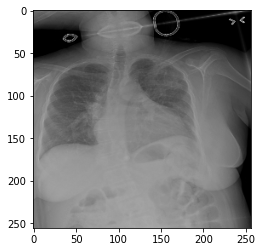

In [14]:
plt.imshow(xb[0][0],cmap='gray')

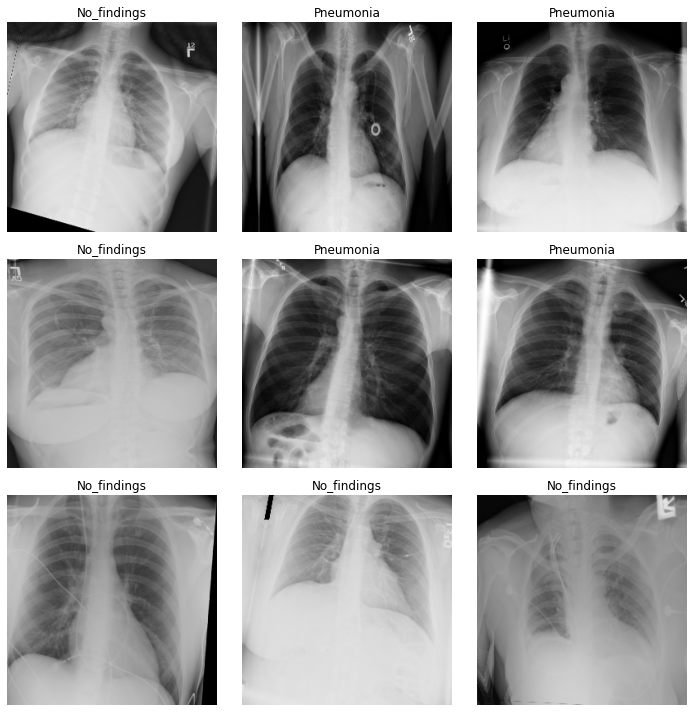

In [15]:
data.show_batch(rows=3, figsize=(10,10))

## DarkCovidNet (modified Darknet model)

In [16]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))

In [17]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [18]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [19]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 3),
    Flatten(),
    nn.Linear(507, 3)
)

In [20]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [21]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [22]:
learn.fit_one_cycle(5, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.896484,1.541386,0.422222,02:42
1,0.834549,0.685705,0.711111,02:29
2,0.800940,0.968844,0.671111,02:25
3,0.735842,0.649931,0.800000,02:24
4,0.669580,0.613743,0.764444,02:26


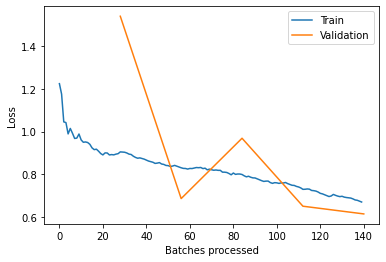

In [23]:
learn.recorder.plot_losses()

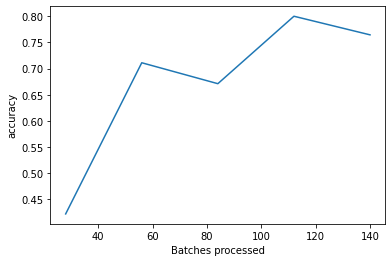

In [24]:
learn.recorder.plot_metrics()

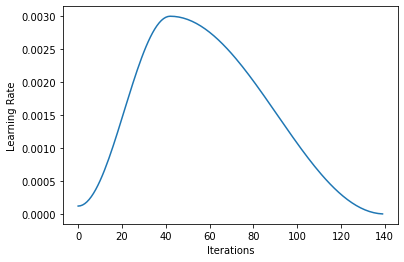

In [25]:
learn.recorder.plot_lr()

In [26]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 225


In [27]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) # Predicting without TTA

In [28]:
accuracy(probs,targets)

tensor(0.7644)

In [29]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings', 'Pneumonia'], 3, 900, 225)

In [30]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) # shows whole confusion matrix
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings', 'Pneumonia']
print(classification_report(y_true1, y_pred1, target_names=target_names))

225 172 0.7644444444444445
[[ 7  3 15]
 [ 0 94  6]
 [ 0 29 71]]
              precision    recall  f1-score   support

    Covid-19       1.00      0.28      0.44        25
 No_findings       0.75      0.94      0.83       100
   Pneumonia       0.77      0.71      0.74       100

    accuracy                           0.76       225
   macro avg       0.84      0.64      0.67       225
weighted avg       0.79      0.76      0.75       225



In [31]:
interp = ClassificationInterpretation.from_learner(learn)

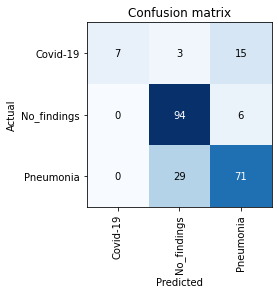

In [32]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);

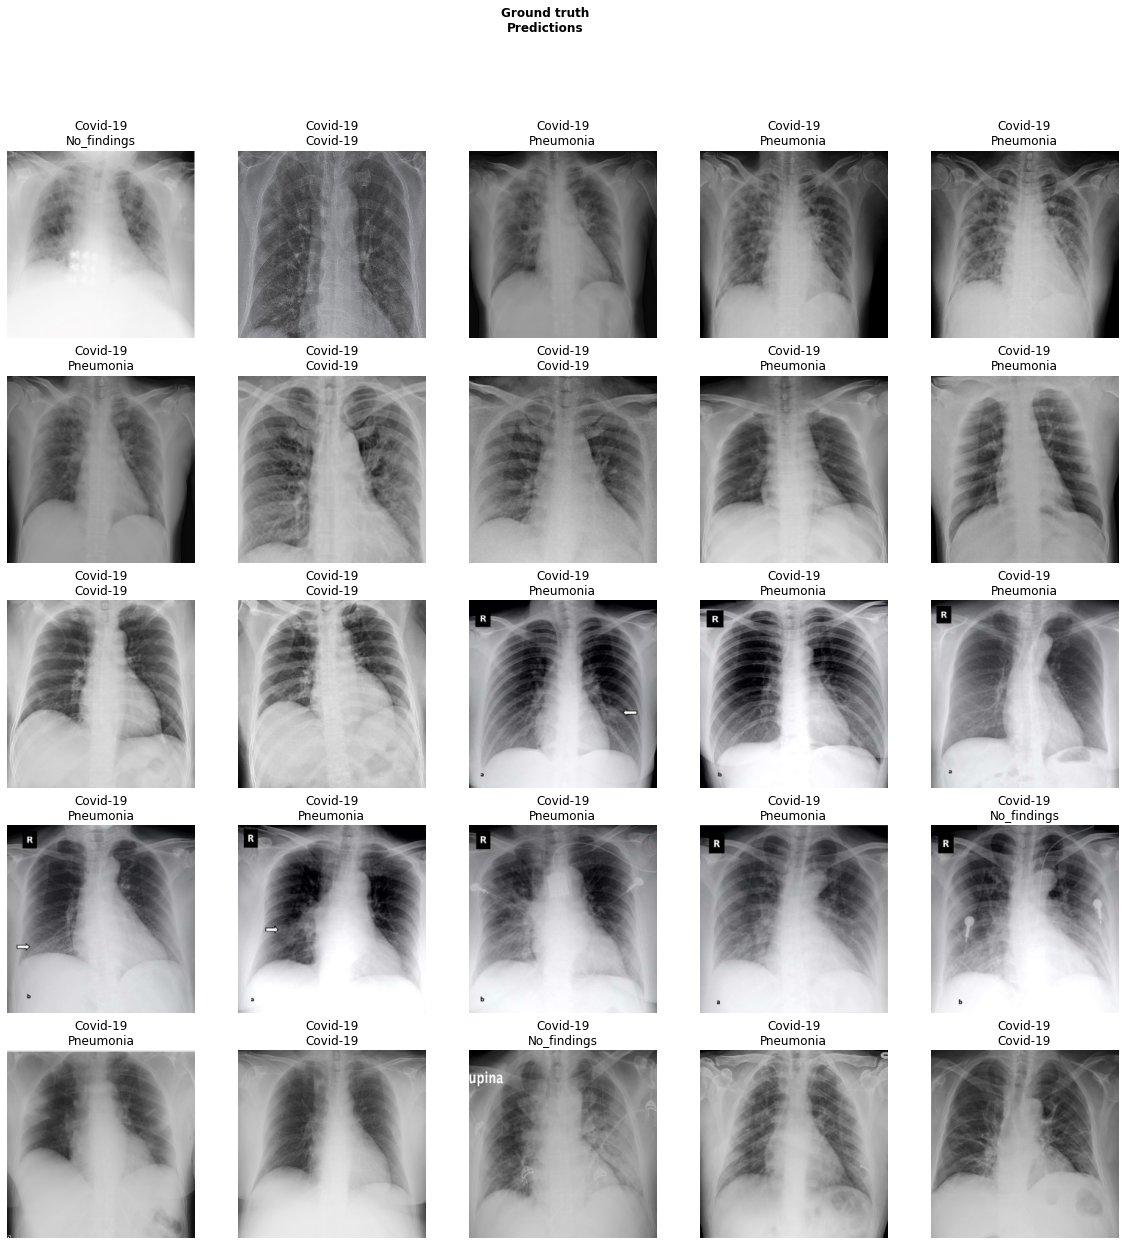

In [33]:
learn.show_results(max_n=16)

In [34]:
# learn.save('covid_classifier_model',return_path=True)

WindowsPath('dataset/models/covid_classifier_model.pth')

In [36]:
learn.export('model.pkl')
print('done')

done


In [ ]:
# simple test

In [44]:
learner = load_learner(path='covid_classifier_model',file='model.pkl')

In [65]:
img = open_image(r"dataset\Valid\No_findings\00001280_004.png")

In [66]:
cat,tensor,probs=learner.predict(img)
print(cat)

No_findings
